# Рекомендательные системы. Гибридные рекомендательные системы.

> На этом практическом занятии мы с вами сделаем следующее:
- Посмотри как работает LightFM.
- Сравним качество и скорость BRP и WARP.
- Построим простейший сервис для рекомендаций используя LightFM.

## Импортируем библиотеку LightFM

In [3]:
import numpy as np
import pandas as pd
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k
from lightfm.datasets import fetch_movielens

from flask import Flask, jsonify, request

In [4]:
movielens = fetch_movielens()
train, test = movielens['train'], movielens['test']

In [5]:
train.todense()

matrix([[5, 3, 4, ..., 0, 0, 0],
        [4, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [5, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 5, 0, ..., 0, 0, 0]], dtype=int32)

## Сравним качество BRP и WARP

Зададим общие гиперпараметры

In [21]:
alpha = 1e-05
epochs = 80
num_components = 32

In [7]:
warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha)

In [8]:
bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

In [11]:
logistic_model = LightFM(no_components=num_components,
                    loss='logistic',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

In [12]:
warp_duration = []
bpr_duration = []
logistic_duration = []
warp_auc = []
bpr_auc = []
logistic_auc = []

In [17]:
for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=10)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())

for epoch in range(epochs):
    start = time.time()
    bpr_model.fit_partial(train, epochs=10)
    bpr_duration.append(time.time() - start)
    bpr_auc.append(auc_score(bpr_model, test, train_interactions=train).mean())
    
for epoch in range(epochs):
    start = time.time()
    logistic_model.fit_partial(train, epochs=10)
    logistic_duration.append(time.time() - start)
    logistic_auc.append(auc_score(warp_model, test, train_interactions=train).mean())

#### AUC

Посмотрим на результаты обучения. Видно, что WARP гораздо точнее BRP. Видно также, что после 10 эпох качество снижается - модель начинает переобучаться.

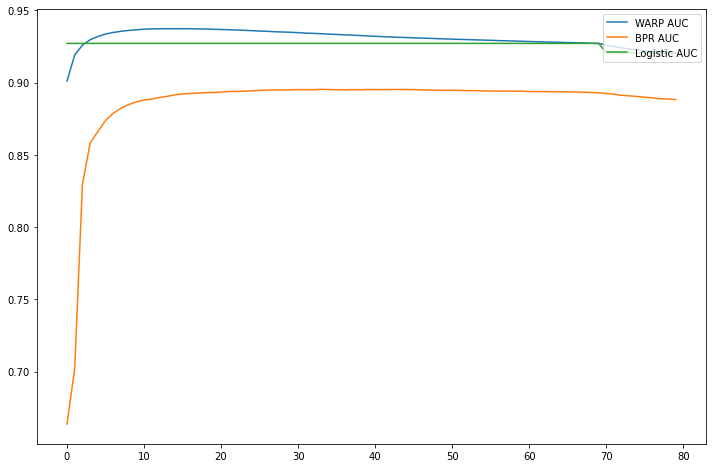

In [22]:
x = np.arange(epochs)
plt.figure(figsize = (12, 8))
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.plot(x, np.array(logistic_auc))
plt.legend(['WARP AUC', 'BPR AUC' , 'Logistic AUC'], loc='upper right') #
plt.show()

#### Скорость

BRP обучается быстрее. Видно также, что чем ближе к концу обучения, тем WARP обучается дольше. Это связано с тем, что чем лучше модель обучилась, тем больше надо перебрать негативных объектов, чтобы найти пример нарушения ранжирования.

> max_sampled гиперпарамеетр в WARP отвечает за максимальное количество попыток найти нарушение ранжирования.

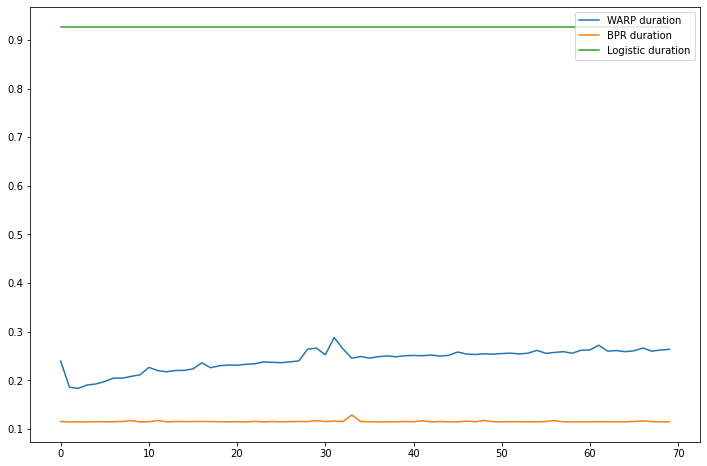

In [15]:
x = np.arange(epochs)
plt.figure(figsize = (12, 8))
plt.plot(x, np.array(warp_duration))
plt.plot(x, np.array(bpr_duration))
plt.plot(x, np.array(logistic_auc))
plt.legend(['WARP duration', 'BPR duration', 'Logistic duration'], loc='upper right')
plt.show()

## По традиции запустим сервис рекомендаций

In [24]:
data = fetch_movielens(min_rating=4.0)

In [25]:
model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(data['train'], epochs=10)

train_precision = precision_at_k(model, data['train'], k=10).mean()
test_precision = precision_at_k(model, data['test'], k=10).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.49, test 0.06.


In [ ]:
# create app
app = Flask(__name__)

In [ ]:
# API endpoint
@app.route('/')
def recom_for_user():
    user_id = request.args.get('user_id', default = 1, type = int)
    
    n_users, n_items = data['train'].shape
    known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
    scores = model.predict(user_id, np.arange(n_items))
    top_items = data['item_labels'][np.argsort(-scores)][:10]
    
    movie_scores = zip(top_items, scores)
    
    return jsonify(
        movies=[
            {
                "id": i,
                "score": float(s),
            }
            for i, s in movie_scores
        ],
    )

In [ ]:
app.run(host="0.0.0.0", port=5000)